
# Trackintel case study - Tracking dataset comparison
This notebook presents a case-study to jointly analyse four different tracking datasets using [trackintel](https://github.com/mie-lab/trackintel). 
Three of the datasets that are used in this case study can not be published to protect the privacy of the participants. You can find an executable example notebook for trackintel here: [binder](https://mybinder.org/v2/gh/mie-lab/trackintel/HEAD?urlpath=https%3A%2F%2Fgithub.com%2Fmie-lab%2Ftrackintel%2Fblob%2Fmaster%2Fexamples%2Ftrackintel_basic_tutorial.ipynb) [code](https://github.com/mie-lab/trackintel/blob/master/examples/trackintel_basic_tutorial.ipynb)

## Imports

In [71]:
import os, sys
from collections import defaultdict
import pickle

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import psycopg2
import json
import seaborn as sns
from shapely.geometry import Point
from sqlalchemy import create_engine

import trackintel as ti
from trackintel.analysis.tracking_quality import temporal_tracking_quality
from trackintel.analysis.modal_split import calculate_modal_split
from trackintel.visualization.modal_split import plot_modal_split

In [64]:
out_path = "./temp"
os.makedirs(out_path, exist_ok=True)

path_to_geolife = "~/Downloads/Geolife Trajectories 1.3/Data"
# r"E:\Geolife Trajectories 1.3\Data"

DBLOGIN_FILE_GC = "../../dblogin_commit.json"
# r"C:\Users\henry\OneDrive\Programming\21_mobility-graph-clustering\dblogin_source.json"
DBLOGIN_FILE_yumuv = "../../dblogin_mielab.json"

with open(DBLOGIN_FILE_GC) as json_file:
    LOGIN_DATA_GC = json.load(json_file)

with open(DBLOGIN_FILE_yumuv) as json_file:
    LOGIN_DATA_YUMUV = json.load(json_file)
    
con_gc = psycopg2.connect( # requires ssh tunnel
        dbname=LOGIN_DATA_GC["database"],
        user=LOGIN_DATA_GC["user"],
        password=LOGIN_DATA_GC["password"],
        host=LOGIN_DATA_GC["host"],
        port=LOGIN_DATA_GC["port"],
)

con_yumuv = psycopg2.connect(
        dbname=LOGIN_DATA_YUMUV["database"],
        user=LOGIN_DATA_YUMUV["user"],
        password=LOGIN_DATA_YUMUV["password"],
        host=LOGIN_DATA_YUMUV["host"],
        port=LOGIN_DATA_YUMUV["port"],
)

con_casestudy = psycopg2.connect(
        dbname="case_study_cache",
        user=LOGIN_DATA_YUMUV["user"],
        password=LOGIN_DATA_YUMUV["password"],
        host=LOGIN_DATA_YUMUV["host"],
        port=LOGIN_DATA_YUMUV["port"],
)

engine_casestudy = create_engine("postgresql://{user}:{password}@{host}:{port}/case_study_cache".format(**LOGIN_DATA_YUMUV))

CRS_WGS84 = "epsg:4326"

In [6]:
studies = ["gc1", "gc2", "yumuv_graph_rep", "geolife"]

# Full names for plotting
study_mapping = {"gc1":"Green Class 1", "gc2": "Green Class 2", "yumuv_graph_rep": "Yumuv", "geolife":"Geolife"}

In [7]:
# filter for debugging (2 users per dataset)
filter_sql = """where user_id = ANY('{"155", "51", "58", "1729", "1761", "2379ddac-f662-49a5-84be-6fae5c91a7e3", "e09fad5f-5b4b-4af5-a24d-0c0ef705199a", "c9aa08e2-1a5d-4d41-ae62-6110a9072b23", "15956", "15604"}'::text[])"""

# Part 1: Dataset loading and preprocessing

## Datasets
We include the data from four tracking studies with two different tracking data types.

### Green Class 1 & 2 
The Green Class 1 & 2 studies were conducted in collaboration with the Swiss Federal Railway Systems (SBB) under the project name [SBB Green Class](https://www.researchgate.net/publication/335858551_Analysis_framework_and_results_of_the_SBB_Green_Class_pilot_studies)
In both studies, participants were given full access to all public transport in Switzerland. In addition, the participants from the first Green Class study (Green Class 1) received an electric vehicle and the ones from the second study (Green Class 2) an e-bike. Study participants were tracked with a GNSS-based application (app) that provides partially preprocessed data as staypoints and triplegs.
### Geolife
The first study is the open-source [Geolife dataset](https://www.microsoft.com/en-us/download/details.aspx?id=52367&from=https%3A%2F%2Fresearch.microsoft.com%2Fen-us%2Fdownloads%2Fb16d359d-d164-469e-9fd4-daa38f2b2e13%2F) that covers the movement of employees of Microsoft Research Asia. The dataset is from about 2012 and was still recorded with dedicated GPS-only trackers. As the study took place in an urban area the GPS was unreliable and there are many gaps in the dataset. However, Geolife is still one of the few publicly available tracking datasets.

### Yumuv
The [yumuv](https://www.research-collection.ethz.ch/handle/20.500.11850/521380) study investigated the impact of a [Mobility-as-a-Service app](https://yumuv.ch/en) that integrates shared e-scooters, e-bikes and public transport. In the yumuv study, participants were divided into control and treatment group and were tracked for three months using an app that already provides staypoints and triplegs.


# Import data
One main advantage of trackintel is its ability to standardize the preprocessing of tracking data. For this, the different datasets have to be imported to geopandas dataframes that fulfill the requirements described [here](https://trackintel.readthedocs.io/en/latest/modules/model.html).

The trackintel data model consists of these different classes:

- positionfixes [pfs]: Raw GPS data.
- staypoints [sp]: Locations where a user spent a minimal time.
- triplegs [tpls]: Segments covered with one mode of transport.
- locations [loc]: Clustered staypoints.
- trips: Segments between consecutive activity staypoints (special staypoints that are not just waiting points).
- tours: Sequences of trips which start and end at the same location (if the column ‘journey’ is True, this location is home).

The Geolife dataset consists of only positionfixes while the other datasets are already processed to staypoints and triplegs by the tracking app. We will now import all datasets and combine them on the staypoints / triplegs level


## Import Geolife
Geolife is an important benchmark dataset. Trackintel therefore offers a dedicated function that reads in the Geolife dataset. The import function takes care of the required column format and names.


In [8]:
import trackintel
from trackintel.io.dataset_reader import read_geolife
pfs_geolife, _ = read_geolife(path_to_geolife, print_progress=True)
pfs_geolife.head(3)

100%|█████████████████████████████████████████████████████████████████████| 182/182 [01:07<00:00,  2.71it/s]


,elevation,tracked_at,geom,user_id,accuracy
id,,,,,
0,149.9616,2009-01-03 01:21:34+00:00,POINT (116.39974 39.97429),135,NaN
1,149.9616,2009-01-03 01:21:35+00:00,POINT (116.39959 39.97429),135,NaN
2,149.9616,2009-01-03 01:21:36+00:00,POINT (116.39952 39.97431),135,NaN


### Geolife - Generate staypoints
We generate staypoints from the positionfixes and define all staypoints as relevant activities if they are longer than 25 minutes.

In [10]:
# extract staypoints
pfs_geolife, sp_geolife = pfs_geolife.as_positionfixes.generate_staypoints(
    gap_threshold=24 * 60, include_last=True, print_progress=True, dist_threshold=200, time_threshold=30, n_jobs=4)
sp_geolife['study'] = 'Geolife'

# add activity flag to staypoints
sp_geolife = sp_geolife.as_staypoints.create_activity_flag(method="time_threshold", time_threshold=25)
sp_geolife.head(3)

/Users/ninawiedemann/miniconda3/envs/trackintel/lib/python3.8/site-packages/trackintel/preprocessing/positionfixes.py:111: UserWarning: 146900 duplicates were dropped from your positionfixes. Dropping duplicates is recommended but can be prevented using the 'exclude_duplicate_pfs' flag.
  warnings.warn(warn_str)
100%|█████████████████████████████████████████████████████████████████████| 182/182 [02:25<00:00,  1.25it/s]


,user_id,started_at,finished_at,elevation,geom,study,is_activity
id,,,,,,,
0,0,2008-10-23 03:03:45+00:00,2008-10-23 04:08:07+00:00,61.7220,POINT (116.29917 39.98341),Geolife,True
1,0,2008-10-23 04:32:52+00:00,2008-10-23 09:42:25+00:00,53.9496,POINT (116.32451 39.99967),Geolife,True
2,0,2008-10-23 11:10:42+00:00,2008-10-24 02:10:09+00:00,26.8224,POINT (116.32105 40.00917),Geolife,True


### Geolife - Generate triplegs

In [13]:
%%time
pfs_geolife, tpls_geolife = pfs_geolife.as_positionfixes.generate_triplegs(sp_geolife, method="between_staypoints", gap_threshold=25)
tpls_geolife['study'] = 'Geolife'
tpls_geolife.head(3)

/Users/ninawiedemann/miniconda3/envs/trackintel/lib/python3.8/site-packages/trackintel/preprocessing/positionfixes.py:504: UserWarning: The positionfixes with ids [ 1755569  1755570 16930452 16930453 18354597 18354598 18454492 18454493
 22498022 22498023 22950461 22950462  6954760  6954761 16361884 16361885
  6065236  6065237 21005748 21005749 10849502 10849503 10171066 10171067] lead to invalid tripleg geometries. The resulting triplegs were omitted and the tripleg id of the positionfixes was set to nan
  warnings.warn(warn_string)


CPU times: user 6min 39s, sys: 40.2 s, total: 7min 19s
Wall time: 7min 56s


,user_id,started_at,finished_at,geom,study
id,,,,,
0,0,2008-10-23 02:53:04+00:00,2008-10-23 03:03:40+00:00,"LINESTRING (116.31842 39.98470, 116.31845 39.9...",Geolife
1,0,2008-10-23 04:08:07+00:00,2008-10-23 04:32:47+00:00,"LINESTRING (116.28680 39.99578, 116.28545 39.9...",Geolife
2,0,2008-10-23 09:42:25+00:00,2008-10-23 11:10:37+00:00,"LINESTRING (116.32016 40.00478, 116.32039 40.0...",Geolife


## Import Green Class 1 & 2
The other datasets are stored in a postgis database and were already preprocessed to staypoints (static behavior) and triplegs (movement). To use them with trackintel, the data has to be adjusted to the data model. This means to create a geodataframe with the correct column names and timezone aware timestamps.


### Green class - Staypoints

In [18]:
sp_gc = []
for study in ['gc1', 'gc2']:
    # download data
    sp_temp = gpd.GeoDataFrame.from_postgis(sql=f"SELECT * FROM {study}.staypoints",
        con=con_gc, geom_col="geometry_raw", index_col="id")
    
    # transform to trackintel dataframe
    sp_temp = ti.io.read_staypoints_gpd(sp_temp, geom_col='geom', tz='UTC', crs=CRS_WGS84,
                                                 mapper={"geometry_raw": "geom", "purpose_validated": "purpose"})

    # green class specific definition of activities
    sp_temp = sp_temp.as_staypoints.create_activity_flag(method="time_threshold", time_threshold=25)
    meaningful_purpose = ~sp_temp["purpose"].isin(["wait", "unknown"])
    sp_temp.loc[meaningful_purpose, 'is_activity'] = True
    
    # keep study as attribute
    sp_temp['study'] = study_mapping[study]
    
    sp_gc.append(sp_temp)


/Users/ninawiedemann/miniconda3/envs/trackintel/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


### Green class - Triplegs

In [19]:
tpls_gc = []
for study in ['gc1', 'gc2']:
    # downlaod data using geopandas
    tpls_temp = gpd.GeoDataFrame.from_postgis(
        sql=f"SELECT * FROM {study}.triplegs where ST_isValid(geometry)",con=con_gc,
        crs=CRS_WGS84, geom_col="geometry", index_col="id")
    # transform to trackintel dataframe
    tpls_temp = ti.io.read_triplegs_gpd(tpls_temp, geom_col='geom',
        crs=CRS_WGS84,
        tz='UTC',
        mapper={"geometry": "geom", "mode_validated": "mode"})
    # keep study as attribute
    tpls_temp['study'] = study_mapping[study]
    
    tpls_gc.append(tpls_temp)

/Users/ninawiedemann/miniconda3/envs/trackintel/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/ninawiedemann/miniconda3/envs/trackintel/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


## Import yumuv

### yumuv - Staypoints

In [20]:
sp_yumuv = ti.io.read_staypoints_postgis("select * from yumuv.staypoint", con=con_yumuv, geom_col='geometry', 
                                         crs=CRS_WGS84, index_col="id", tz="UTC",
                                        mapper={'user_fk': 'user_id'})

sp_yumuv = sp_yumuv.rename({'geometry': 'geom'}, axis=1).set_geometry('geom')
sp_yumuv['study'] = 'Yumuv'
sp_yumuv = sp_yumuv.as_staypoints.create_activity_flag(time_threshold=25)
sp_yumuv['user_id'] = sp_yumuv['user_id'] + 10000

/Users/ninawiedemann/miniconda3/envs/trackintel/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


### yumuv - Triplegs

In [21]:
tpls_yumuv = ti.io.postgis.read_triplegs_postgis("select distinct on (id) * FROM yumuv.tripleg where ST_isvalid(geometry)", con=con_yumuv, geom_col='geometry', 
                                                 crs=CRS_WGS84, index_col="id", tz="UTC", mapper={'user_fk': 'user_id'}
                                                )
tpls_yumuv = tpls_yumuv.rename({'geometry': 'geom', 'track_mode_corrected': 'mode'}, axis=1).set_geometry('geom')
tpls_yumuv['study'] = 'Yumuv'
tpls_yumuv['user_id'] = tpls_yumuv['user_id'] + 10000

/Users/ninawiedemann/miniconda3/envs/trackintel/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


## Combine studies

Create one staypoints and one triplegs dataframe for all studies together

### All studies - combine staypoints

In [22]:
staypoints = pd.concat([sp_geolife] + sp_gc + [sp_yumuv])
staypoints['user_id'] = staypoints['user_id'].astype(str)

### All studies - combine triplegs

In [23]:
triplegs = pd.concat([tpls_geolife] + tpls_gc + [tpls_yumuv])
triplegs['user_id'] = triplegs['user_id'].astype(str)

In [25]:
triplegs['geom'] = triplegs.simplify(1e-4, preserve_topology=False)

In [26]:
# enforce valid geometries for triplegs
# AssertionError: Not all geometries are valid. Try x[~ x.geometry.is_valid] where x is you GeoDataFram
triplegs = triplegs[triplegs.geometry.is_valid]

offset ids to ensure unique IDs

In [27]:
for ix, study in enumerate(study_mapping.values()):
    sp_study_flag = staypoints['study'] == study
    tpls_study_flag = triplegs['study'] == study
    
    staypoints.loc[sp_study_flag].index = staypoints.loc[sp_study_flag].index + ix * 10e7
    triplegs.loc[tpls_study_flag].index = triplegs.loc[tpls_study_flag].index + ix * 10e7

In [ ]:
staypoints

Check invalid time stamps

In [34]:
valid_tstamp_flag_sp = staypoints.started_at <= staypoints.finished_at
valid_tstamp_flag_tpls = triplegs.started_at <= triplegs.finished_at
print("number of invalid times (start > end) for sp:", (~ valid_tstamp_flag_sp).sum())
print("number of invalid times (start > end) for sp:", (~valid_tstamp_flag_tpls).sum())

number of invalid times (start > end) for sp: 1
number of invalid times (start > end) for sp: 1


##### drop outliers


In [33]:
user_study_matching = staypoints[['user_id', 'study']].drop_duplicates()
user_study_matching = user_study_matching.set_index('user_id')

### All studies - create trips

In [35]:
staypoints, triplegs, trips = ti.preprocessing.triplegs.generate_trips(staypoints=staypoints, triplegs=triplegs,
                                                                       gap_threshold=15, add_geometry=True)

/Users/ninawiedemann/miniconda3/envs/trackintel/lib/python3.8/site-packages/trackintel/preprocessing/triplegs.py:112: UserWarning: Deleted existing column 'trip_id' from tpls.
  warnings.warn("Deleted existing column 'trip_id' from tpls.")
/Users/ninawiedemann/miniconda3/envs/trackintel/lib/python3.8/site-packages/trackintel/preprocessing/triplegs.py:118: UserWarning: Deleted column 'trip_id' from staypoints.
  warnings.warn(f"Deleted column '{col}' from staypoints.")
/Users/ninawiedemann/miniconda3/envs/trackintel/lib/python3.8/site-packages/trackintel/preprocessing/triplegs.py:118: UserWarning: Deleted column 'prev_trip_id' from staypoints.
  warnings.warn(f"Deleted column '{col}' from staypoints.")
/Users/ninawiedemann/miniconda3/envs/trackintel/lib/python3.8/site-packages/trackintel/preprocessing/triplegs.py:118: UserWarning: Deleted column 'next_trip_id' from staypoints.
  warnings.warn(f"Deleted column '{col}' from staypoints.")
/Users/ninawiedemann/miniconda3/envs/trackintel/lib

In [36]:
trips = trips.join(user_study_matching, on='user_id')

### All studies - create locations

In [37]:
staypoints, locations = ti.preprocessing.generate_locations(staypoints, epsilon=30, num_samples=1, 
                                                distance_metric='haversine', print_progress=True,
                                                n_jobs=4)

100%|███████████████████████████████████████████████████████████████████| 1179/1179 [00:21<00:00, 55.89it/s]
/Users/ninawiedemann/miniconda3/envs/trackintel/lib/python3.8/site-packages/pandas/core/apply.py:1137: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  mapped = lib.map_infer(


In [38]:
locations = locations.join(user_study_matching, on='user_id')

### All studies - create tours

In [39]:
trips, tours = ti.preprocessing.generate_tours(trips, staypoints=staypoints,  print_progress=True)
tours['started_at'] = pd.to_datetime(tours['started_at'])
tours['finished_at'] = pd.to_datetime(tours['finished_at'])

User trip generation: 100%|█████████████████████████████████████████████| 1193/1193 [05:30<00:00,  3.61it/s]


In [40]:
tours = tours.join(user_study_matching, on='user_id')

## Write intermediate outputs to database

In [ ]:
print("check that index is unique:")
assert staypoints.index.is_unique
assert triplegs.index.is_unique
assert trips.index.is_unique
assert tours.index.is_unique
assert locations.index.is_unique

In [28]:
staypoints.as_staypoints.to_postgis("staypoints", con=engine_casestudy, if_exists='replace')

In [29]:
triplegs.as_triplegs.to_postgis("triplegs", con=engine_casestudy, if_exists="replace", chunksize=10000)

C:\Users\henry\.conda\envs\geodev\lib\site-packages\geopandas\io\sql.py:431: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  gdf.to_sql(


In [30]:
locations.as_locations.to_postgis("locations", con=engine_casestudy, if_exists="replace")

In [31]:
trips.as_trips.to_postgis("trips", con=engine_casestudy, if_exists="replace")

In [32]:
tours.as_tours.to_postgis("tours", con=engine_casestudy, if_exists="replace")

## Load from cache

In [33]:
debug_flag = False

In [34]:
if debug_flag:
    staypoints = ti.io.postgis.read_staypoints_postgis(f"SELECT * from staypoints {filter_sql}", con=engine_casestudy, geom_col='geom', 
                                                   index_col="id")
    triplegs = ti.io.postgis.read_triplegs_postgis(f"SELECT * from triplegs {filter_sql} and ST_isvalid(geom)", con=engine_casestudy, geom_col='geom', 
                                                   index_col="id")
    locations = ti.io.postgis.read_locations_postgis(f"SELECT * from locations {filter_sql}", con=engine_casestudy, index_col='id')
    trips = ti.io.postgis.read_trips_postgis(f"SELECT * FROM trips {filter_sql}", con=engine_casestudy, index_col='id')
    tours = ti.io.postgis.read_tours_postgis(f"SELECT * FROM tours {filter_sql}", con=engine_casestudy, index_col='id')


# Part 2: Dataset comparison

## 1) Simple Statistics

Number of users, number of trips, number of trips by user, etc

In [46]:
overview_df = pd.DataFrame(index=study_mapping.values())

overview_df['nr_user'] = staypoints.groupby(by=['study']).agg({"user_id": "nunique"})
nr_user = overview_df['nr_user']

# nb staypooints
overview_df['nr_sp'] = staypoints.groupby(by=['study']).size()
overview_df['nr_staypoints_per_user'] = overview_df['nr_sp']/nr_user

# nb triplegs
overview_df['nr_tpls'] = triplegs.groupby(by=['study']).size()
overview_df['nr_triplegs_per_user'] = overview_df['nr_tpls']/nr_user

# nb trips
overview_df['nr_trips'] = trips.groupby(by=['study']).size()
overview_df['nr_trips_per_user'] = overview_df['nr_trips']/nr_user
# nb locations

overview_df['nr_loc'] = locations.groupby(by=['study']).size()
overview_df['nr_locations_per_user'] = overview_df['nr_loc']/nr_user

# nb tours
overview_df['nr_tours'] = tours.groupby(by=['study']).size()
overview_df['nr_tours_per_user'] = overview_df['nr_tours']/nr_user


In [47]:
overview_df

,nr_user,nr_sp,nr_staypoints_per_user,nr_tpls,nr_triplegs_per_user,nr_trips,nr_trips_per_user,nr_loc,nr_locations_per_user,nr_tours,nr_tours_per_user
Green Class 1,139,326926,2351.985612,465169,3346.539568,241825,1739.748201,104497,751.776978,94982,683.323741
Green Class 2,50,87884,1757.680000,128599,2571.980000,61412,1228.240000,35715,714.300000,22701,454.020000
Yumuv,813,553966,681.384994,833112,1024.738007,321658,395.643296,178784,219.906519,150461,185.068881
Geolife,177,28877,163.146893,30205,170.649718,30199,170.615819,13575,76.694915,7184,40.587571


## 2) Trip characteristics

* How many trips comprise one tour on average? How many triplegs comprise a trip?
* What is the average trip duration / distance?

#### Number of hops in tours

In [48]:
tours['nb_hops'] = tours["trips"].apply(lambda x: len(x))
overview_df['avg_hops_tours'] =  tours.groupby('study')['nb_hops'].mean() 

#### Trip duration

In [51]:
trips['duration_s'] = (trips['finished_at'] - trips['started_at']).dt.total_seconds() / 3600

In [52]:
overview_df[["mean_trip_dur", "std_trip_dur"]] = trips.groupby('study')['duration_s'].aggregate(['mean', 'std'])
overview_df = overview_df.round({'mean_trip_dur': 2, 'std_trip_dur': 2})
overview_df

,nr_user,nr_sp,nr_staypoints_per_user,nr_tpls,nr_triplegs_per_user,nr_trips,nr_trips_per_user,nr_loc,nr_locations_per_user,nr_tours,nr_tours_per_user,avg_hops_tours,mean_trip_dur,std_trip_dur
Green Class 1,139,326926,2351.985612,465169,3346.539568,241825,1739.748201,104497,751.776978,94982,683.323741,2.725201,0.52,0.73
Green Class 2,50,87884,1757.680000,128599,2571.980000,61412,1228.240000,35715,714.300000,22701,454.020000,2.657020,0.51,0.75
Yumuv,813,553966,681.384994,833112,1024.738007,321658,395.643296,178784,219.906519,150461,185.068881,1.999036,0.69,0.91
Geolife,177,28877,163.146893,30205,170.649718,30199,170.615819,13575,76.694915,7184,40.587571,2.373469,0.64,0.94


#### Overall tracking period and number of trips per day per user

In [53]:
min_max_times_by_user = trips.groupby(['study', 'user_id']).aggregate({'started_at': 'min', 'finished_at': 'max'})
duration_by_user = (min_max_times_by_user['finished_at'] - min_max_times_by_user['started_at']).dt.total_seconds() / (3600 * 24)
overview_df[["mean_tracking_period", "std_tracking_period"]] = duration_by_user.groupby('study').aggregate(['mean', 'std'])
overview_df

,nr_user,nr_sp,nr_staypoints_per_user,nr_tpls,nr_triplegs_per_user,nr_trips,nr_trips_per_user,nr_loc,nr_locations_per_user,nr_tours,nr_tours_per_user,avg_hops_tours,mean_trip_dur,std_trip_dur,mean_tracking_period,std_tracking_period
Green Class 1,139,326926,2351.985612,465169,3346.539568,241825,1739.748201,104497,751.776978,94982,683.323741,2.725201,0.52,0.73,401.639038,59.289224
Green Class 2,50,87884,1757.680000,128599,2571.980000,61412,1228.240000,35715,714.300000,22701,454.020000,2.657020,0.51,0.75,314.203054,76.458555
Yumuv,813,553966,681.384994,833112,1024.738007,321658,395.643296,178784,219.906519,150461,185.068881,1.999036,0.69,0.91,158.631668,147.100416
Geolife,177,28877,163.146893,30205,170.649718,30199,170.615819,13575,76.694915,7184,40.587571,2.373469,0.64,0.94,193.216082,443.133363


In [54]:
# average trips per day on days with data
trips_temp = trips.set_index('started_at')
nr_trips_per_user_per_day = trips_temp.groupby(['study', 'user_id', pd.Grouper(freq='D')]).size().groupby('study').mean() 
overview_df['nr_trips_per_user_per_day'] = nr_trips_per_user_per_day

In [55]:
# average trips per day over full tracking period
nr_trips_per_user_per_day = (trips.groupby(['study', 'user_id']).size() / duration_by_user).groupby('study').mean()

# there are some outliers that have tracked <<< 1 day (due to the limit set by me)

#### Trip distance

In [56]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

In [57]:
triplegs['length_in_m'] = ti.geogr.distances.calculate_haversine_length(triplegs)
# update pygeos

In [58]:
metrics_per_trip = triplegs.groupby(['study', 'trip_id']).agg({"trip_id": "count", "length_in_m":"sum"})
overview_df[["nr_legs_per_trip", "avg_trip_length", "std_trip_length"
            ]] = metrics_per_trip.groupby('study').agg({'trip_id': 'mean', 'length_in_m': ["mean", "std"]})

#### Tracking quality

In [59]:
triplegs_staypoints = pd.concat([triplegs, staypoints])
tracking_quality_by_user_study = triplegs_staypoints.groupby('study').apply(temporal_tracking_quality)
overview_df[["mean_tracking_quality", "std_tracking_quality"]] = tracking_quality_by_user_study.groupby('study').agg(['mean', 'std'])


/var/folders/m9/1q3cs2cx43qd5c82ljgh9g3w0000gr/T/ipykernel_27388/1040013140.py:3: FutureWarning: ['user_id'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  overview_df[["mean_tracking_quality", "std_tracking_quality"]] = tracking_quality_by_user_study.groupby('study').agg(['mean', 'std'])


### 3) Finalize results in two tables

#### 3.1) Table with simple dataset stats

In [60]:
overview_df[["nr_user","mean_tracking_period", "std_tracking_period", "nr_loc", "nr_sp", "nr_tpls", "nr_trips", "nr_tours"]]
overview_df.fillna(0, inplace=True)
overview_df

,nr_user,nr_sp,nr_staypoints_per_user,nr_tpls,nr_triplegs_per_user,nr_trips,nr_trips_per_user,nr_loc,nr_locations_per_user,nr_tours,nr_tours_per_user,avg_hops_tours,mean_trip_dur,std_trip_dur,mean_tracking_period,std_tracking_period,nr_trips_per_user_per_day,nr_legs_per_trip,avg_trip_length,std_trip_length,mean_tracking_quality,std_tracking_quality
Green Class 1,139,326926,2351.985612,465169,3346.539568,241825,1739.748201,104497,751.776978,94982,683.323741,2.725201,0.52,0.73,401.639038,59.289224,4.888316,1.923577,26977.094601,3.575098e+05,0.846193,0.170514
Green Class 2,50,87884,1757.680000,128599,2571.980000,61412,1228.240000,35715,714.300000,22701,454.020000,2.657020,0.51,0.75,314.203054,76.458555,4.770235,2.094037,32428.279621,4.972113e+05,0.753781,0.237542
Yumuv,813,553966,681.384994,833112,1024.738007,321658,395.643296,178784,219.906519,150461,185.068881,1.999036,0.69,0.91,158.631668,147.100416,3.297839,2.589934,16863.618838,1.087605e+05,0.751018,0.251450
Geolife,177,28877,163.146893,30205,170.649718,30199,170.615819,13575,76.694915,7184,40.587571,2.373469,0.64,0.94,193.216082,443.133363,2.758403,1.000000,35954.468302,3.163539e+06,0.397451,0.317477


In [61]:
# basic info
df_basic = overview_df[["nr_user","mean_tracking_period", "std_tracking_period", "nr_loc", "nr_sp", "nr_tpls", "nr_trips", "nr_tours"]].astype(int)

In [62]:
df_basic["Tracking period (std)"] = df_basic.apply(lambda x: f"{x['mean_tracking_period']} ({x['std_tracking_period']})", axis=1)
df_basic["Available"] = "Staypoints, Triplegs"
df_basic["Study type"] = "GNSS (app)"

# rename columns and index
df_basic = df_basic.rename(columns={"Available": "Input", "nr_user": "Users", "nr_loc": "Locations", "nr_sp": "Staypoints", "nr_tpls": "Triplegs", 
                        "nr_trips": "Trips", "nr_tours": "Tours"}, 
                        index=study_mapping).drop(columns=["mean_tracking_period", "std_tracking_period"])
# select the columns in the right order
df_basic = df_basic[["Users", 'Tracking period (std)' , "Input", "Study type", "Locations", "Staypoints", "Triplegs", "Trips", "Tours"]]

df_basic
# print(df_basic.to_latex())

,Users,Tracking period (std),Input,Study type,Locations,Staypoints,Triplegs,Trips,Tours
Green Class 1,139,401 (59),"Staypoints, Triplegs",GNSS (app),104497,326926,465169,241825,94982
Green Class 2,50,314 (76),"Staypoints, Triplegs",GNSS (app),35715,87884,128599,61412,22701
Yumuv,813,158 (147),"Staypoints, Triplegs",GNSS (app),178784,553966,833112,321658,150461
Geolife,177,193 (443),"Staypoints, Triplegs",GNSS (app),13575,28877,30205,30199,7184


#### 3.2) Table with analysis

In [63]:
# Analysis table
detailed = overview_df[["nr_trips_per_user_per_day", "mean_trip_dur", "std_trip_dur", "avg_hops_tours", "nr_legs_per_trip", "avg_trip_length", "std_trip_length", "mean_tracking_quality", "std_tracking_quality"]]
detailed = detailed.round(2)
# Incorporate mean and std in one cell
detailed["Trip distance (std)"] = detailed.apply(lambda x: f"{int(x['avg_trip_length'])} ({int(x['std_trip_length'])})", axis=1)
detailed["Trip duration (std)"] = detailed.apply(lambda x: f"{x['mean_trip_dur']} ({x['std_trip_dur']})", axis=1)
detailed["Tracking quality (std)"] = detailed.apply(lambda x: f"{x['mean_tracking_quality']} ({x['std_tracking_quality']})", axis=1)

detailed = detailed.rename(columns={"nr_trips_per_user_per_day": "Trips per day", 
                                   "avg_hops_tours": "Trips per tour", 
                                   "nr_legs_per_trip": "Legs per trip"}, 
                          index={"gc1":"Green Class 1", "gc2": "Green Class 2", "yumuv_graph_rep": "Yumuv", "geolife":"Geolife"}
                          ).drop(["avg_trip_length", "std_trip_length", "mean_tracking_quality", "std_tracking_quality",
                                  "mean_trip_dur", "std_trip_dur"
                                 ], axis=1)

detailed
# print(detailed.to_latex())

,Trips per day,Trips per tour,Legs per trip,Trip distance (std),Trip duration (std),Tracking quality (std)
Green Class 1,4.89,2.73,1.92,26977 (357509),0.52 (0.73),0.85 (0.17)
Green Class 2,4.77,2.66,2.09,32428 (497211),0.51 (0.75),0.75 (0.24)
Yumuv,3.30,2.00,2.59,16863 (108760),0.69 (0.91),0.75 (0.25)
Geolife,2.76,2.37,1.00,35954 (3163539),0.64 (0.94),0.4 (0.32)


## 4) KDE plot for user tracking quality distribution

In [66]:
new_df = tracking_quality_by_user_study.reset_index(drop=False, level=0).drop('user_id', axis=1)
new_df = new_df.pivot(columns='study', values='quality')

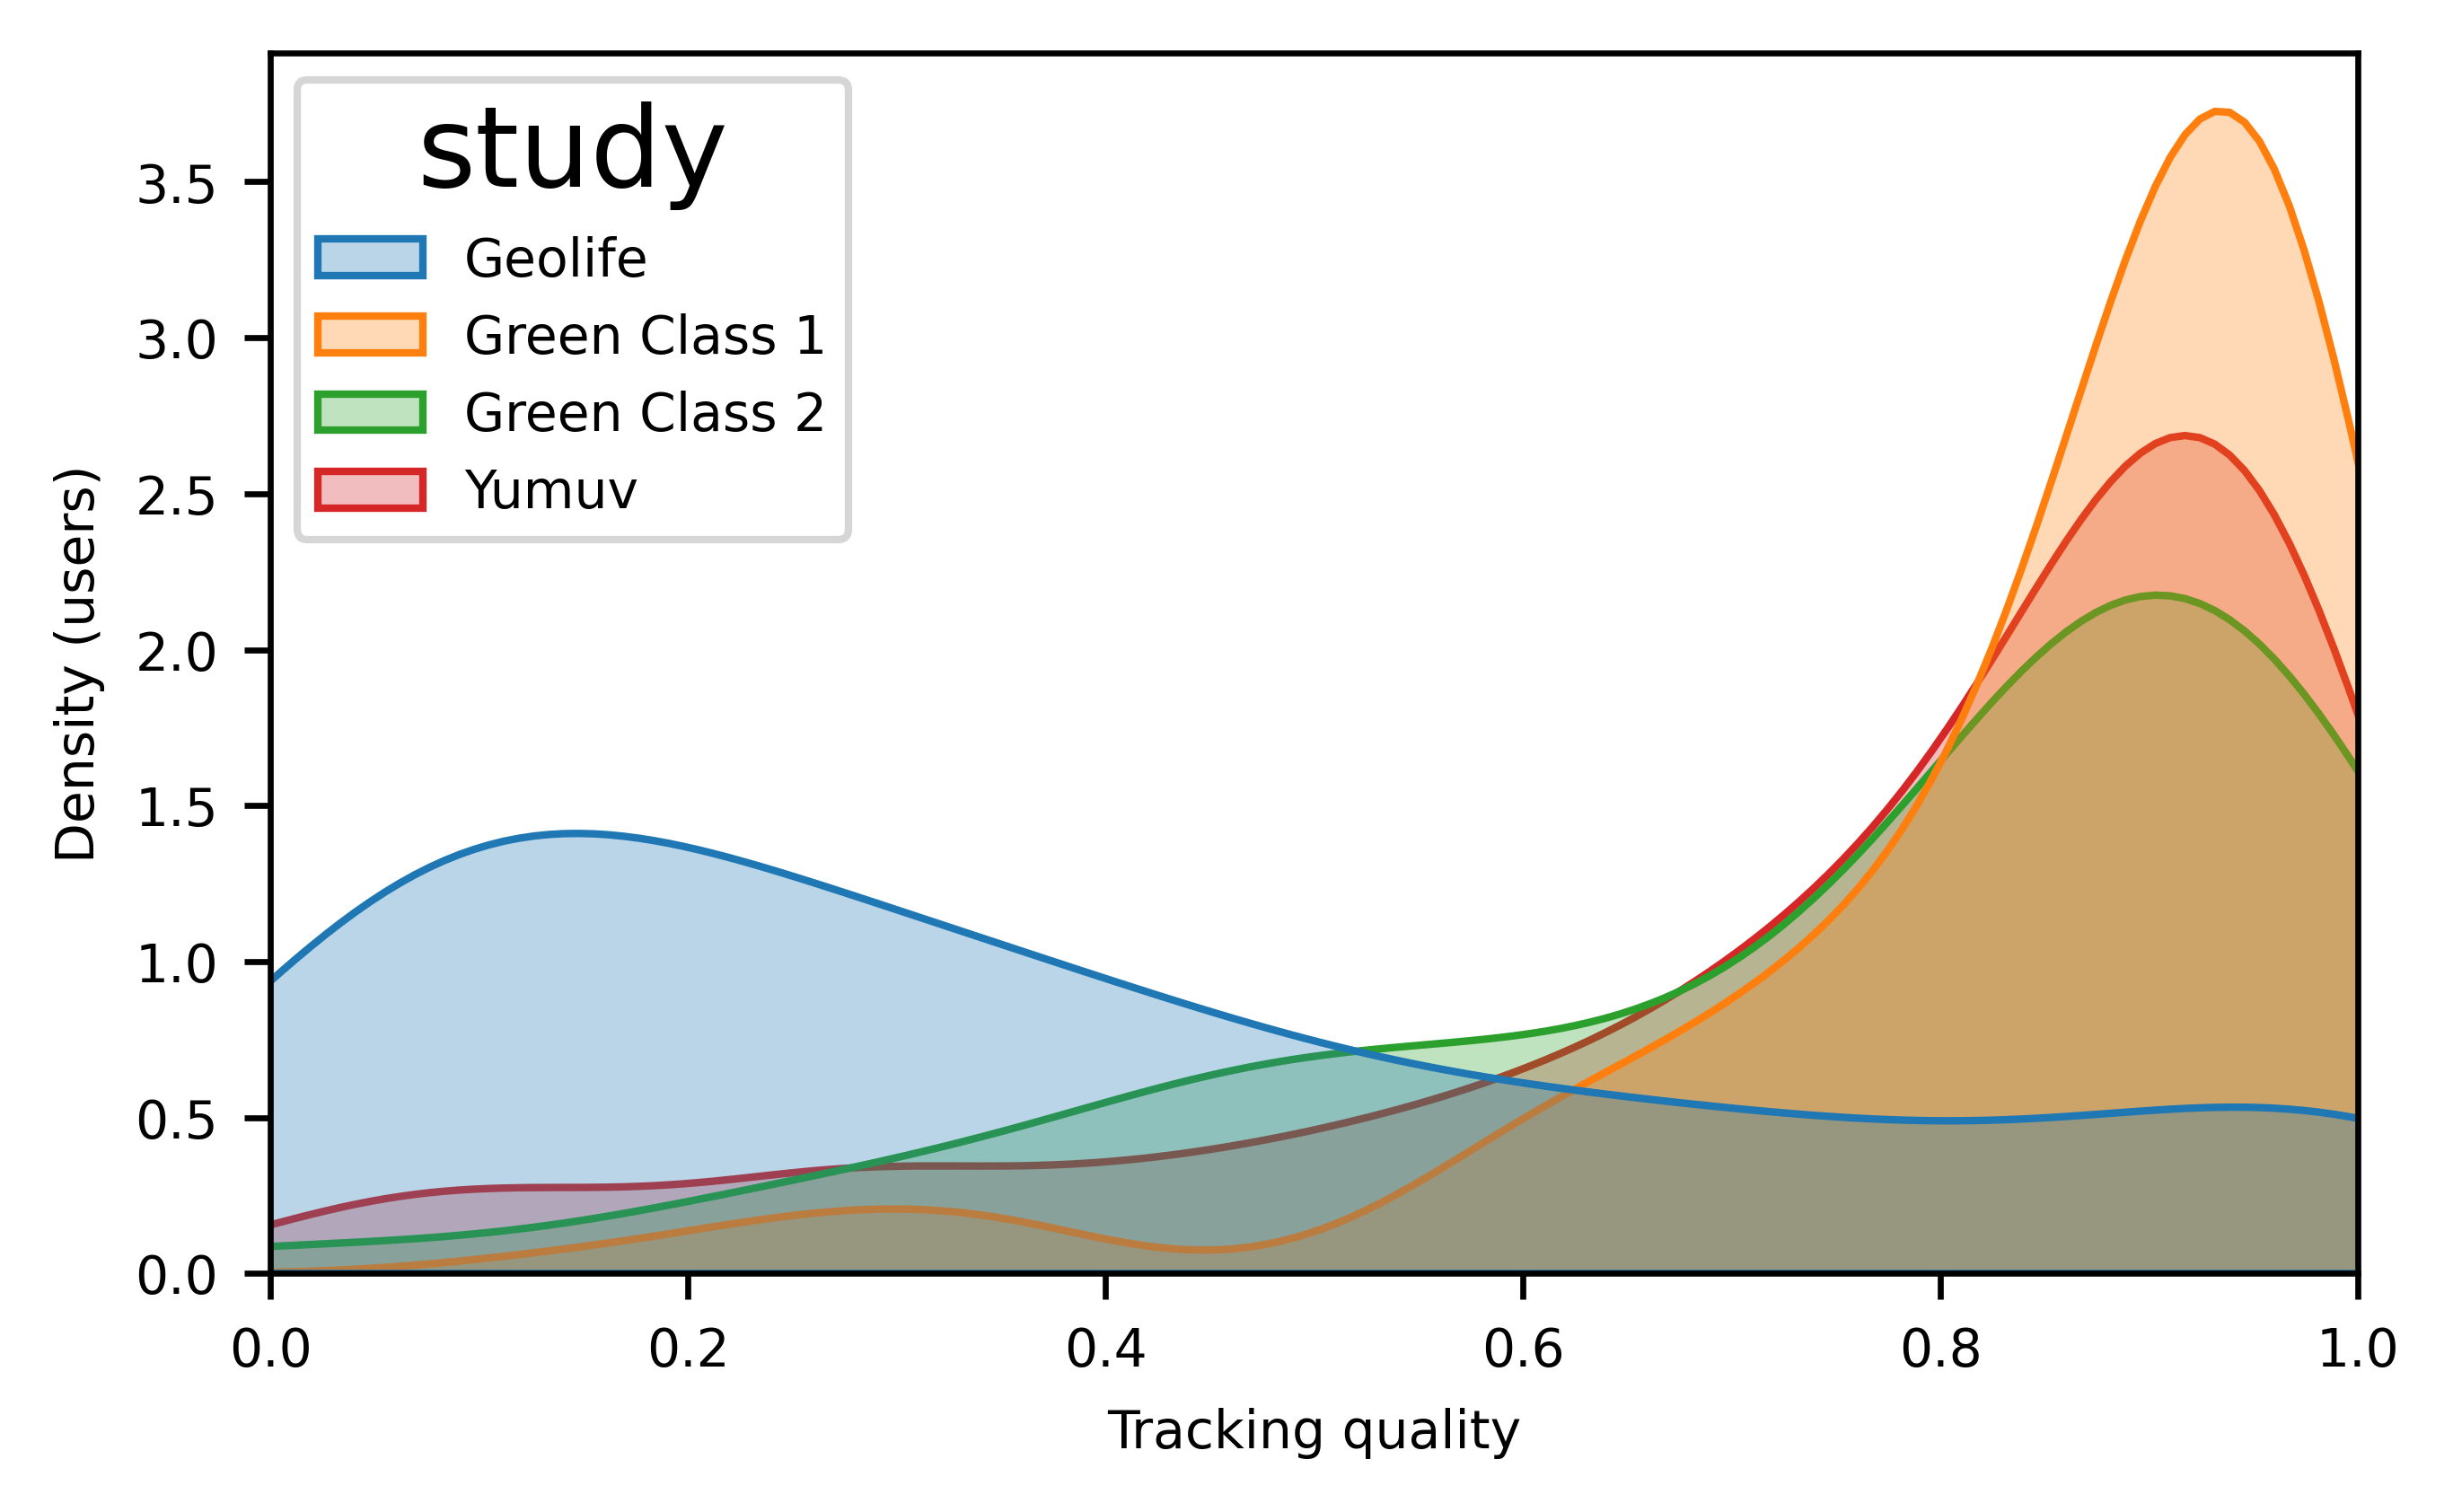

In [115]:
fig, ax = plt.subplots(figsize=(5,3))
plt.rcParams.update({"font.size": 15})
g = sns.kdeplot(data=new_df, fill=True, alpha=.3, legend=True, common_grid=True, common_norm=False, ax=ax)

plt.ylabel("Density (users)")
plt.xlabel("Tracking quality")
sns.move_legend(g, "upper left")
plt.xlim(0, 1)
plt.savefig(os.path.join(out_path, "tracking_quality_kde.png"))
plt.show()

## 5) Modal split dataset comparison

### Get modal split for each study

#### Apply Trackintel function to get the modes for Geolife

In [73]:
is_geolife = triplegs['study'] == 'Geolife'
tpls_geolife = triplegs[is_geolife]

In [74]:
# predict transport mode
triplegs.loc[is_geolife, "mode"] = ti.analysis.labelling.predict_transport_mode(triplegs[is_geolife])

In [ ]:
# we need to map the mode labels from GC1 / GC2 / Yumuv to the ones from geolife
mode_to_category = {
    'Mode::Bicycle': 'slow',
     'Mode::Car': 'motorized',
     'Mode::Train': 'fast',
    'Mode::Walk': 'slow',
    'Mode::Tram': 'motorized',
    'Mode::Bus': 'motorized',
    'Mode::Airplane': 'fast',
    'Mode::Coach': 'motorized',
    'Mode::Ebicycle': 'slow',
    'Mode::Boat': 'slow',
    'Mode::Ecar': 'motorized',
    "fast_mobility": "fast",
    "motorized_mobility": "motorized",
    "slow_mobility": "slow",
    "airplane": "fast", 
    "bicycle": "slow",
    "boat": "slow",
    "bus": "motorized",
    "car": "motorized",
    "coach": "motorized",
    "ebicycle": "slow",
    "kick_scooter": "slow",
    "ecar": "motorized",
    "motorbike": "motorized",
    "ski": "slow",
    "train": "fast",
    "tram": "motorized",
    "walk": "slow",
    "fast": "fast",
    "motorized": "motorized",
    "slow": "slow"
}
# change mode labels with the above mapping
triplegs['mode'] = triplegs['mode'].map(mode_to_category)
triplegs.dropna(subset=['mode'], inplace=True)

### Get modal split by count, duration and distance

In [77]:
# count
modal_split_count = triplegs.groupby('study').apply(calculate_modal_split, metric='count', norm=True)
modal_split_count = modal_split_count.droplevel(1)
modal_split_count

mode,fast,motorized,slow
study,,,
Geolife,0.009270,0.399484,0.591246
Green Class 1,0.128246,0.377725,0.494028
Green Class 2,0.138233,0.257262,0.604505
Yumuv,0.066208,0.258108,0.675683


In [78]:
# duration
modal_split_duration = triplegs.groupby('study').apply(calculate_modal_split, metric='duration', norm=True)
modal_split_duration = modal_split_duration.droplevel(1)
modal_split_duration

mode,fast,motorized,slow
study,,,
Geolife,0.025935,0.459866,0.514199
Green Class 1,0.281666,0.474184,0.244150
Green Class 2,0.285328,0.320524,0.394149
Yumuv,0.145316,0.350479,0.504205


In [79]:
# distance
modal_split_list = []
for study, tpls in triplegs.groupby('study'):
    modal_split_distance = calculate_modal_split(tpls, metric='distance', norm=True)
    modal_split_distance['study'] = study
    modal_split_list.append(modal_split_distance)
    
modal_split_distance = pd.concat(modal_split_list).set_index('study')
modal_split_distance
    

mode,fast,motorized,slow
study,,,
Geolife,0.629708,0.295445,0.074847
Green Class 1,0.535597,0.425737,0.038666
Green Class 2,0.692898,0.238362,0.068740
Yumuv,0.462790,0.437137,0.100073


### Plotting

In [84]:
def plot_modal_split_comparison(name_df, modal_split_df):

    fig, ax = plt.subplots(figsize=(12, 8))
    modal_split_df.plot.bar(stacked=True, color=color, ax=ax)
    fs = 16
    plt.legend(loc="upper right", framealpha=1, fontsize=fs)
    plt.xlabel("Dataset", fontsize=fs)
    plt.ylabel("Modal split", fontsize=fs)
    plt.xticks(fontsize=fs)
    plt.tight_layout()
    plt.savefig(os.path.join(out_path, f"modal_split_all_{name_df}.pdf"), bbox_inches='tight')
    plt.show()
    

In [80]:
triplegs['mode'].unique()

array(['slow', 'motorized', 'fast'], dtype=object)

In [81]:

# triplegs

# extent mode_to_category mapping with the upper case / colon versions
#further_cols = list(modal_split_count["gc1"].columns)
#for col in further_cols:
#    mode_to_category[col] = mode_to_category[col.split("::")[1].lower()] 

In [82]:
colors = ['#1D2F6F', '#8390FA', '#6EAF46', '#FAC748']
color = dict(zip(['fast', 'motorized', 'slow'], ['#1D2F6F', '#8390FA', '#6EAF46']))
color

{'fast': '#1D2F6F', 'motorized': '#8390FA', 'slow': '#6EAF46'}

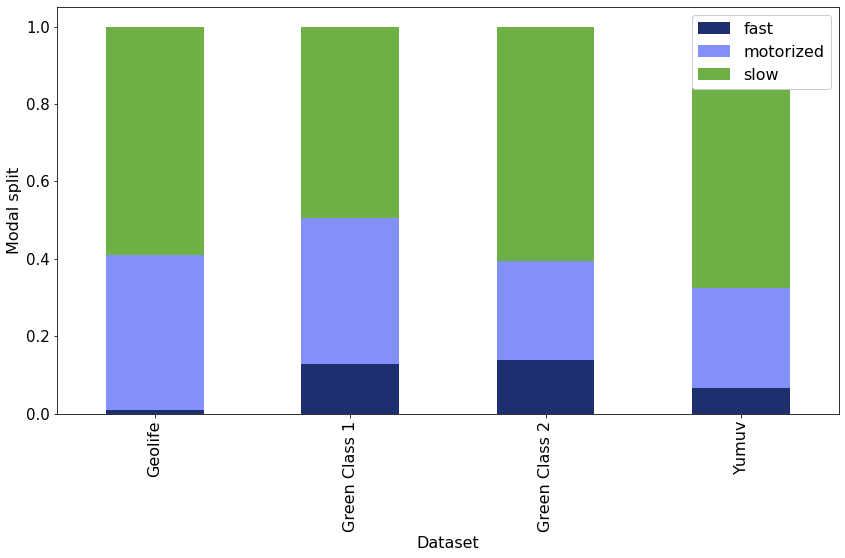

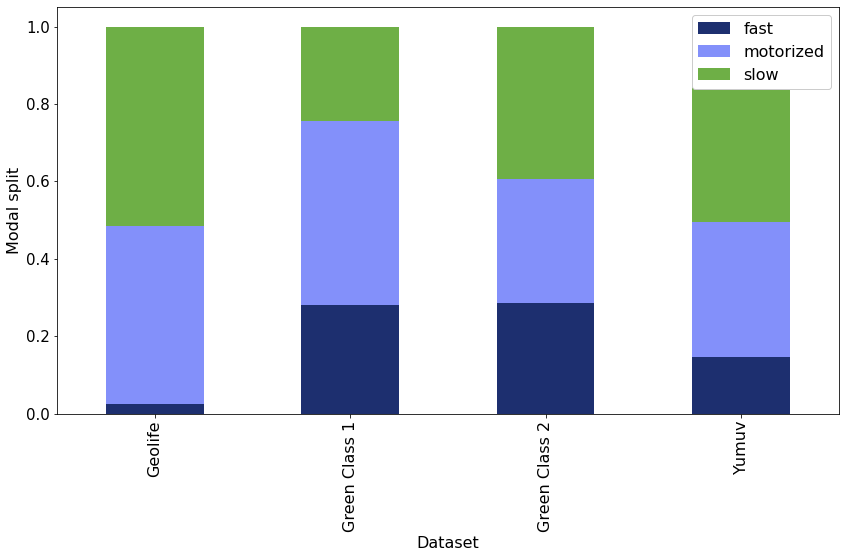

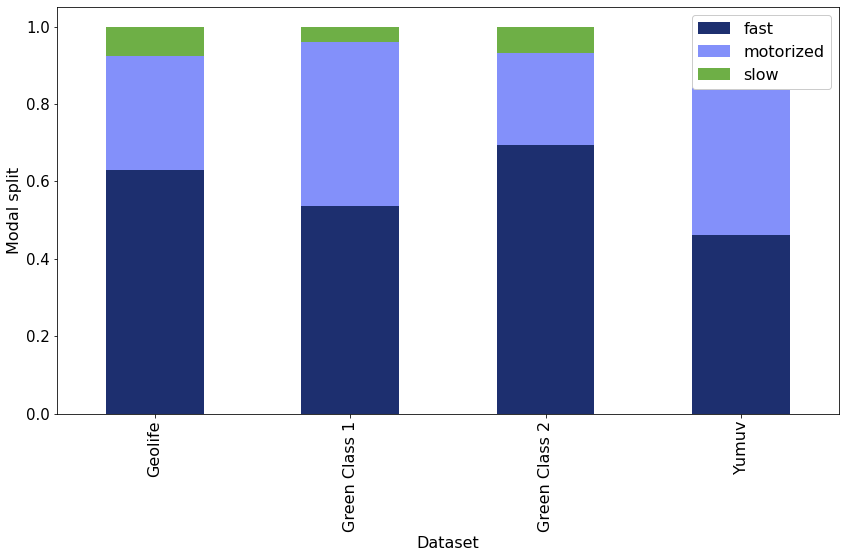

In [85]:
# plotting loop
for name_df, modal_split_df in zip(["count", "duration", "distance"],[modal_split_count, modal_split_duration, modal_split_distance]):
    plot_modal_split_comparison(name_df, modal_split_df)

## 6) Home / Work labeling

In [116]:
# DEFINE MAIN VARIABLE TO PLOT HERE
home_work_variable = "home"

#### Compute staypoint purpose for Geolife and Yumuv

In [86]:
yumuv_geolife_flag = staypoints['study'].isin(['Geolife', 'Yumuv'])
# prefilter argument dict can be replaced with prefilter=False after the next patch
staypoints.loc[yumuv_geolife_flag, 'purpose']  = ti.analysis.location_identifier(staypoints.loc[yumuv_geolife_flag], method="FREQ", pre_filter=False)['purpose']

In [87]:
sp_home = staypoints[staypoints['purpose'] == 'home'].copy()
sp_work = staypoints[staypoints['purpose'] == 'work'].copy()

#### Prepare data

In [88]:
# Use either the home staypoints or the work staypoints
if home_work_variable == "home":
    sp_study = sp_home.copy()
elif home_work_variable == "work":
    sp_study = sp_work.copy()

# convert timestamp columns
sp_study.loc[:, "started_at"]  = sp_study.loc[:, "started_at"].dt.tz_convert("Europe/Paris")
sp_study.loc[:, "finished_at"]  = sp_study.loc[:, "finished_at"].dt.tz_convert("Europe/Paris")

In [89]:
# chop up durations to minute-by-minute time series
sp_study_ = sp_study[['started_at', 'finished_at', 'study']]

sp_study_["date"] = sp_study_.apply(lambda x: pd.date_range(x["started_at"], x["finished_at"],  freq='min'), axis=1)
sp_study_expl = sp_study_.explode("date", ignore_index=True).drop(columns=["started_at", "finished_at"])


/var/folders/m9/1q3cs2cx43qd5c82ljgh9g3w0000gr/T/ipykernel_27388/3889468116.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp_study_["date"] = sp_study_.apply(lambda x: pd.date_range(x["started_at"], x["finished_at"],  freq='min'), axis=1)


In [90]:
# create hour&minute attributes used for aggregation later. Get Geolife in local time zone 
geolife_flag = sp_study_expl['study'] == 'Geolife'

sp_study_expl.loc[~geolife_flag, 'hour'] = sp_study_expl.loc[~geolife_flag, "date"].dt.hour
sp_study_expl.loc[geolife_flag, 'hour'] = sp_study_expl.loc[geolife_flag, "date"].dt.tz_convert("Asia/Shanghai").dt.hour
sp_study_expl['minute'] = sp_study_expl.date.dt.minute

#### Plotting

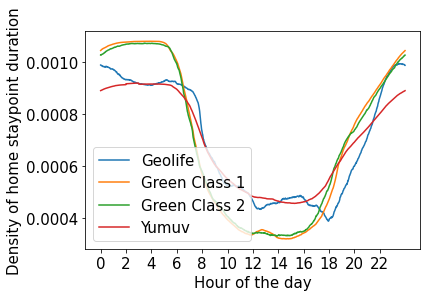

In [91]:
count_by_minute = pd.DataFrame(sp_study_expl.groupby(
    ['study', 'hour', 'minute']).size())
count_by_minute.index.rename(['study', 'hour', 'minute'], inplace=True)
count_by_minute.reset_index(inplace=True)
count_by_minute['minute_of_day'] = (count_by_minute['hour'] * 60 + count_by_minute['minute'])


count_by_minute_pivot = count_by_minute.pivot(columns='study', index='minute_of_day', values=0)
count_by_minute_pivot = count_by_minute_pivot / count_by_minute_pivot.sum(axis=0)
count_by_minute_pivot.plot()
plt.xticks(np.arange(0, len(count_by_minute_pivot.index), 120), np.arange(0,24,2))
plt.legend(loc="lower left")
plt.ylabel(f"Density of {name} staypoint duration")
plt.xlabel("Hour of the day")
plt.savefig(os.path.join(out_path, f"plot_activity_distribution_{home_work_variable}.pdf"))
plt.show()


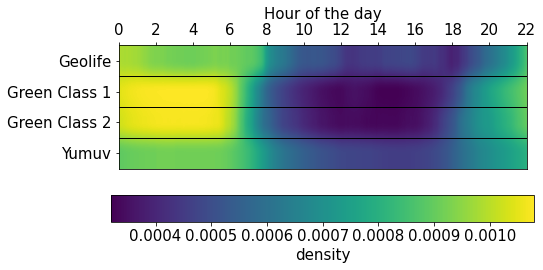

In [92]:
fig, ax = plt.subplots(figsize=(12,4))
home_slots = count_by_minute_pivot.values.transpose()
plt.imshow(home_slots, aspect=100)
for i in range(4):
    plt.plot([0, home_slots.shape[1]], [i+.5, i+.5], c="black", lw=1)
plt.xlim(0, 24)
plt.yticks(np.arange(4), count_by_minute_pivot.columns)
plt.xlabel("Hour of the day")
ax.xaxis.tick_top()
ax.xaxis.tickpad = -2
ax.xaxis.set_label_position("top")
plt.xticks(np.arange(0, len(count_by_minute_pivot.index), 120), np.arange(0,24, 2))
# ax.set_xticklabels(np.arange(0, len(minute_slots), 120), np.arange(0,24, 2))
cbar = plt.colorbar(orientation="horizontal", ax=ax, aspect=16) #anchor=(-1, -1))
cbar.set_label(f"density")
plt.tight_layout()
plt.savefig(os.path.join(out_path, f"imshow_act_distribution_{home_work_variable}.pdf"), bbox_inches='tight')
plt.show()

## 7) Single user visualization

### 7.1 Visualize positionfixes, staypoints and triplegs

In [93]:
from shapely.geometry import Point, Polygon

In [94]:
x_min = 116.2
x_max = 116.5
y_min = 39.8
y_max = 40.1
sw = Point(x_min, y_min)
se = Point(x_max, y_min)
ne = Point(x_max, y_max)
nw = Point(x_min, y_max)

study_area = gpd.GeoDataFrame(columns=['geometry'], data=[Polygon([sw, se, ne, nw])], geometry='geometry', crs="EPSG:4326")


In [108]:
# Load Geolife data of one user
tpls_vis = triplegs[triplegs['user_id']=='51'].copy()
tpls_vis = ti.preprocessing.filter.spatial_filter(tpls_vis, study_area, method='within')

In [109]:
# Get staypoints as well for this user
sp_vis = staypoints[staypoints['user_id']=='51'].copy()
sp_vis = ti.preprocessing.filter.spatial_filter(sp_vis, study_area, method='within')

In [110]:
# Get positionfixes for this user - using the pfs obtained with read_geolife function (see top of notebook)
pfs_vis = pfs_geolife[pfs_geolife["user_id"] == 51]
pfs_vis = ti.preprocessing.filter.spatial_filter(pfs_vis, study_area, method='within')
# Other option: Load from database that stores Geolife positionfixes
# sql = f"SELECT * FROM geolife.positionfixes WHERE user_id='51'"
# pfs_vis = ti.io.read_positionfixes_postgis(sql, con, index_col="id")

In [111]:
ti.visualization.plot_triplegs(tpls_vis, 
                              staypoints= sp_vis,
                               plot_osm=True,
                                positionfixes=pfs_vis,
                              staypoints_radius=150,
                              out_filename=os.path.join(out_path, "geolife_tpls_sp_pfs"))

#### Plot only positionfixes

In [99]:
ti.visualization.plot_positionfixes(pfs_vis,
                                   plot_osm=True,
                                   out_filename=os.path.join(out_path, "geolife_pfs")
                                   )

#### Plot staypoints with positionfixes

In [100]:
ti.visualization.plot_staypoints(sp_vis,
    positionfixes=pfs_vis,
                                plot_osm=True,
                                 radius=150,
                                out_filename=os.path.join(out_path, "geolife_sp_pfs"))

### 7.2) Modal split visualization

In [101]:
# Use one GC2 user for this visualization
tpls_vis = triplegs[triplegs['user_id']=='c9aa08e2-1a5d-4d41-ae62-6110a9072b23'].copy()

In [102]:
# rename to mode
tpls_vis["mode"] = tpls_vis["mode_detected"]

#### Modal split - by count

In [103]:
# compute modal split
modal_split = calculate_modal_split(tpls_vis, freq="M", metric='count', per_user=False, norm=True)

In [104]:
# order the transport modes for colour choices
column_order = ["Mode::Car", "Mode::Bicycle", "Mode::Walk", "Mode::Bus", "Mode::Train", "Mode::Ecar", "Mode::Ebicycle", "Mode::Airplane"]
modal_split = modal_split[column_order]

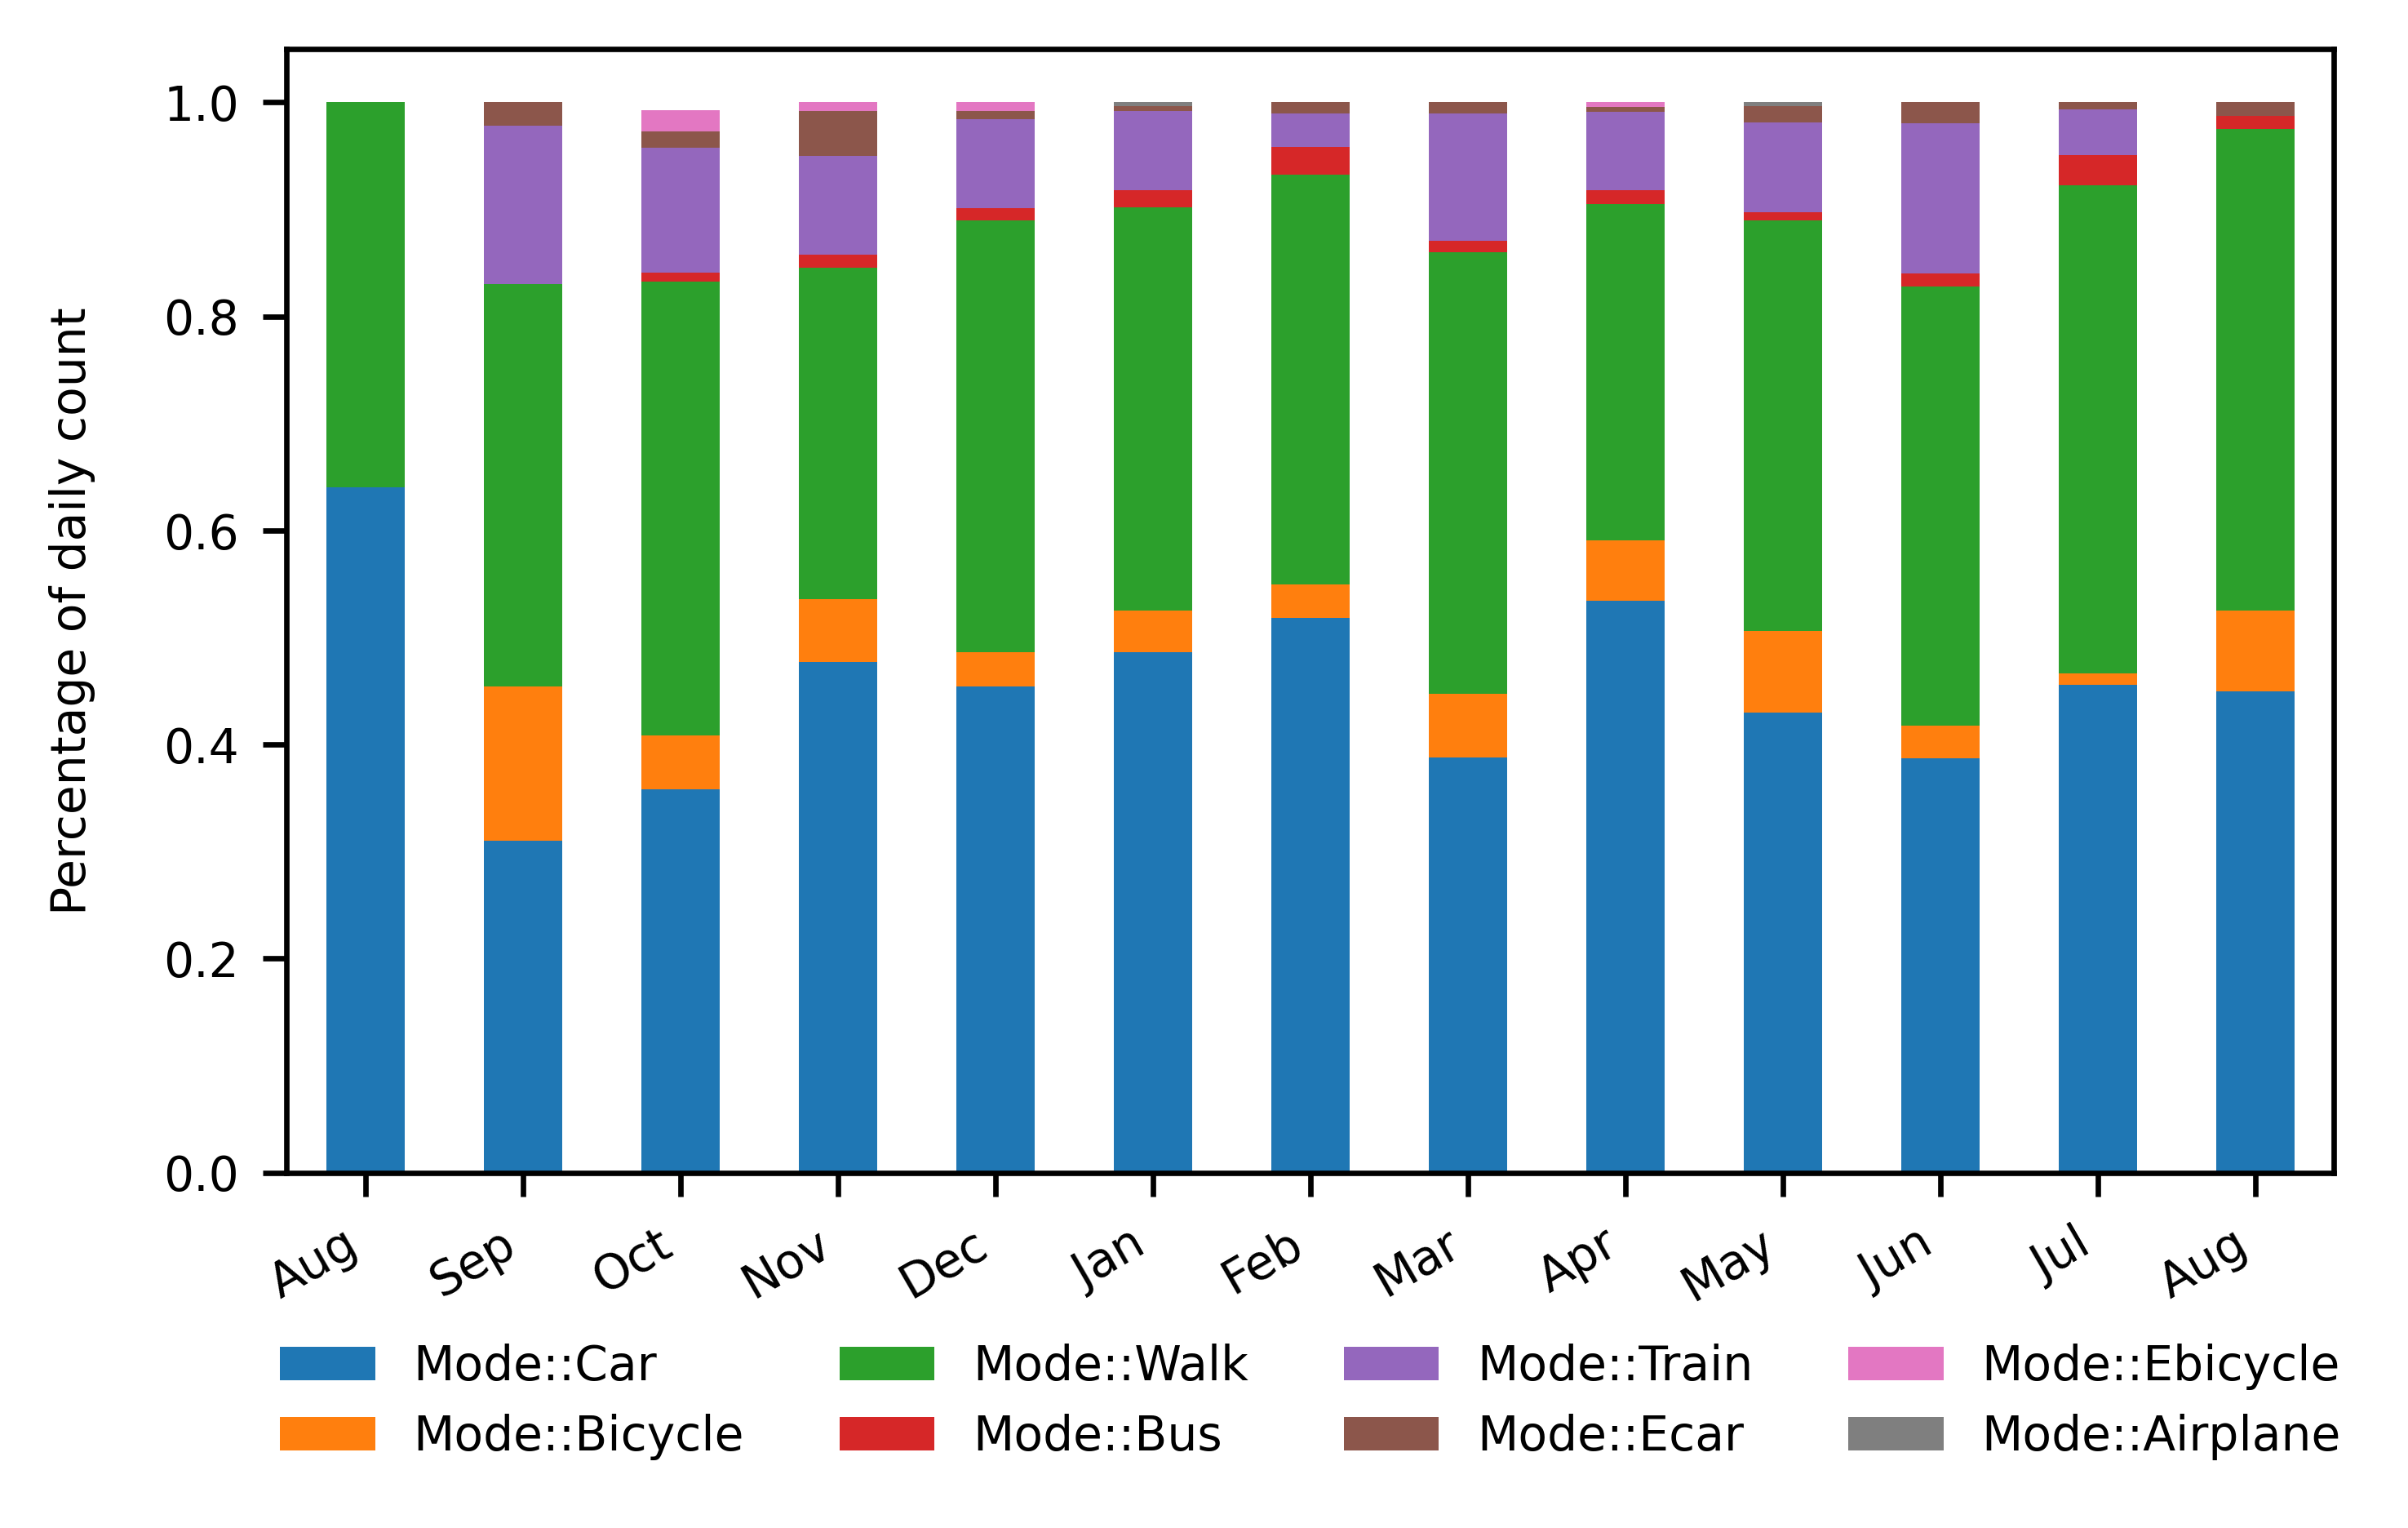

In [105]:
fig, ax = plt.subplots(figsize=(5,3))
ax = ti.visualization.modal_split.plot_modal_split(modal_split, 
                                              date_fmt_x_axis='%b',
                                              y_label='Percentage of daily count',
                                              skip_xticks=0,
                                              n_col_legend=4,
                                                   fig=fig,
                                              axis=ax,
                                             borderaxespad=2
                                             )
fig.autofmt_xdate()
plt.savefig(os.path.join(out_path, "modal_split_count"))

#### Same for distance

In [106]:
modal_split = calculate_modal_split(tpls_vis, freq="M", metric='distance', per_user=False, norm=True)
modal_split = modal_split[column_order]

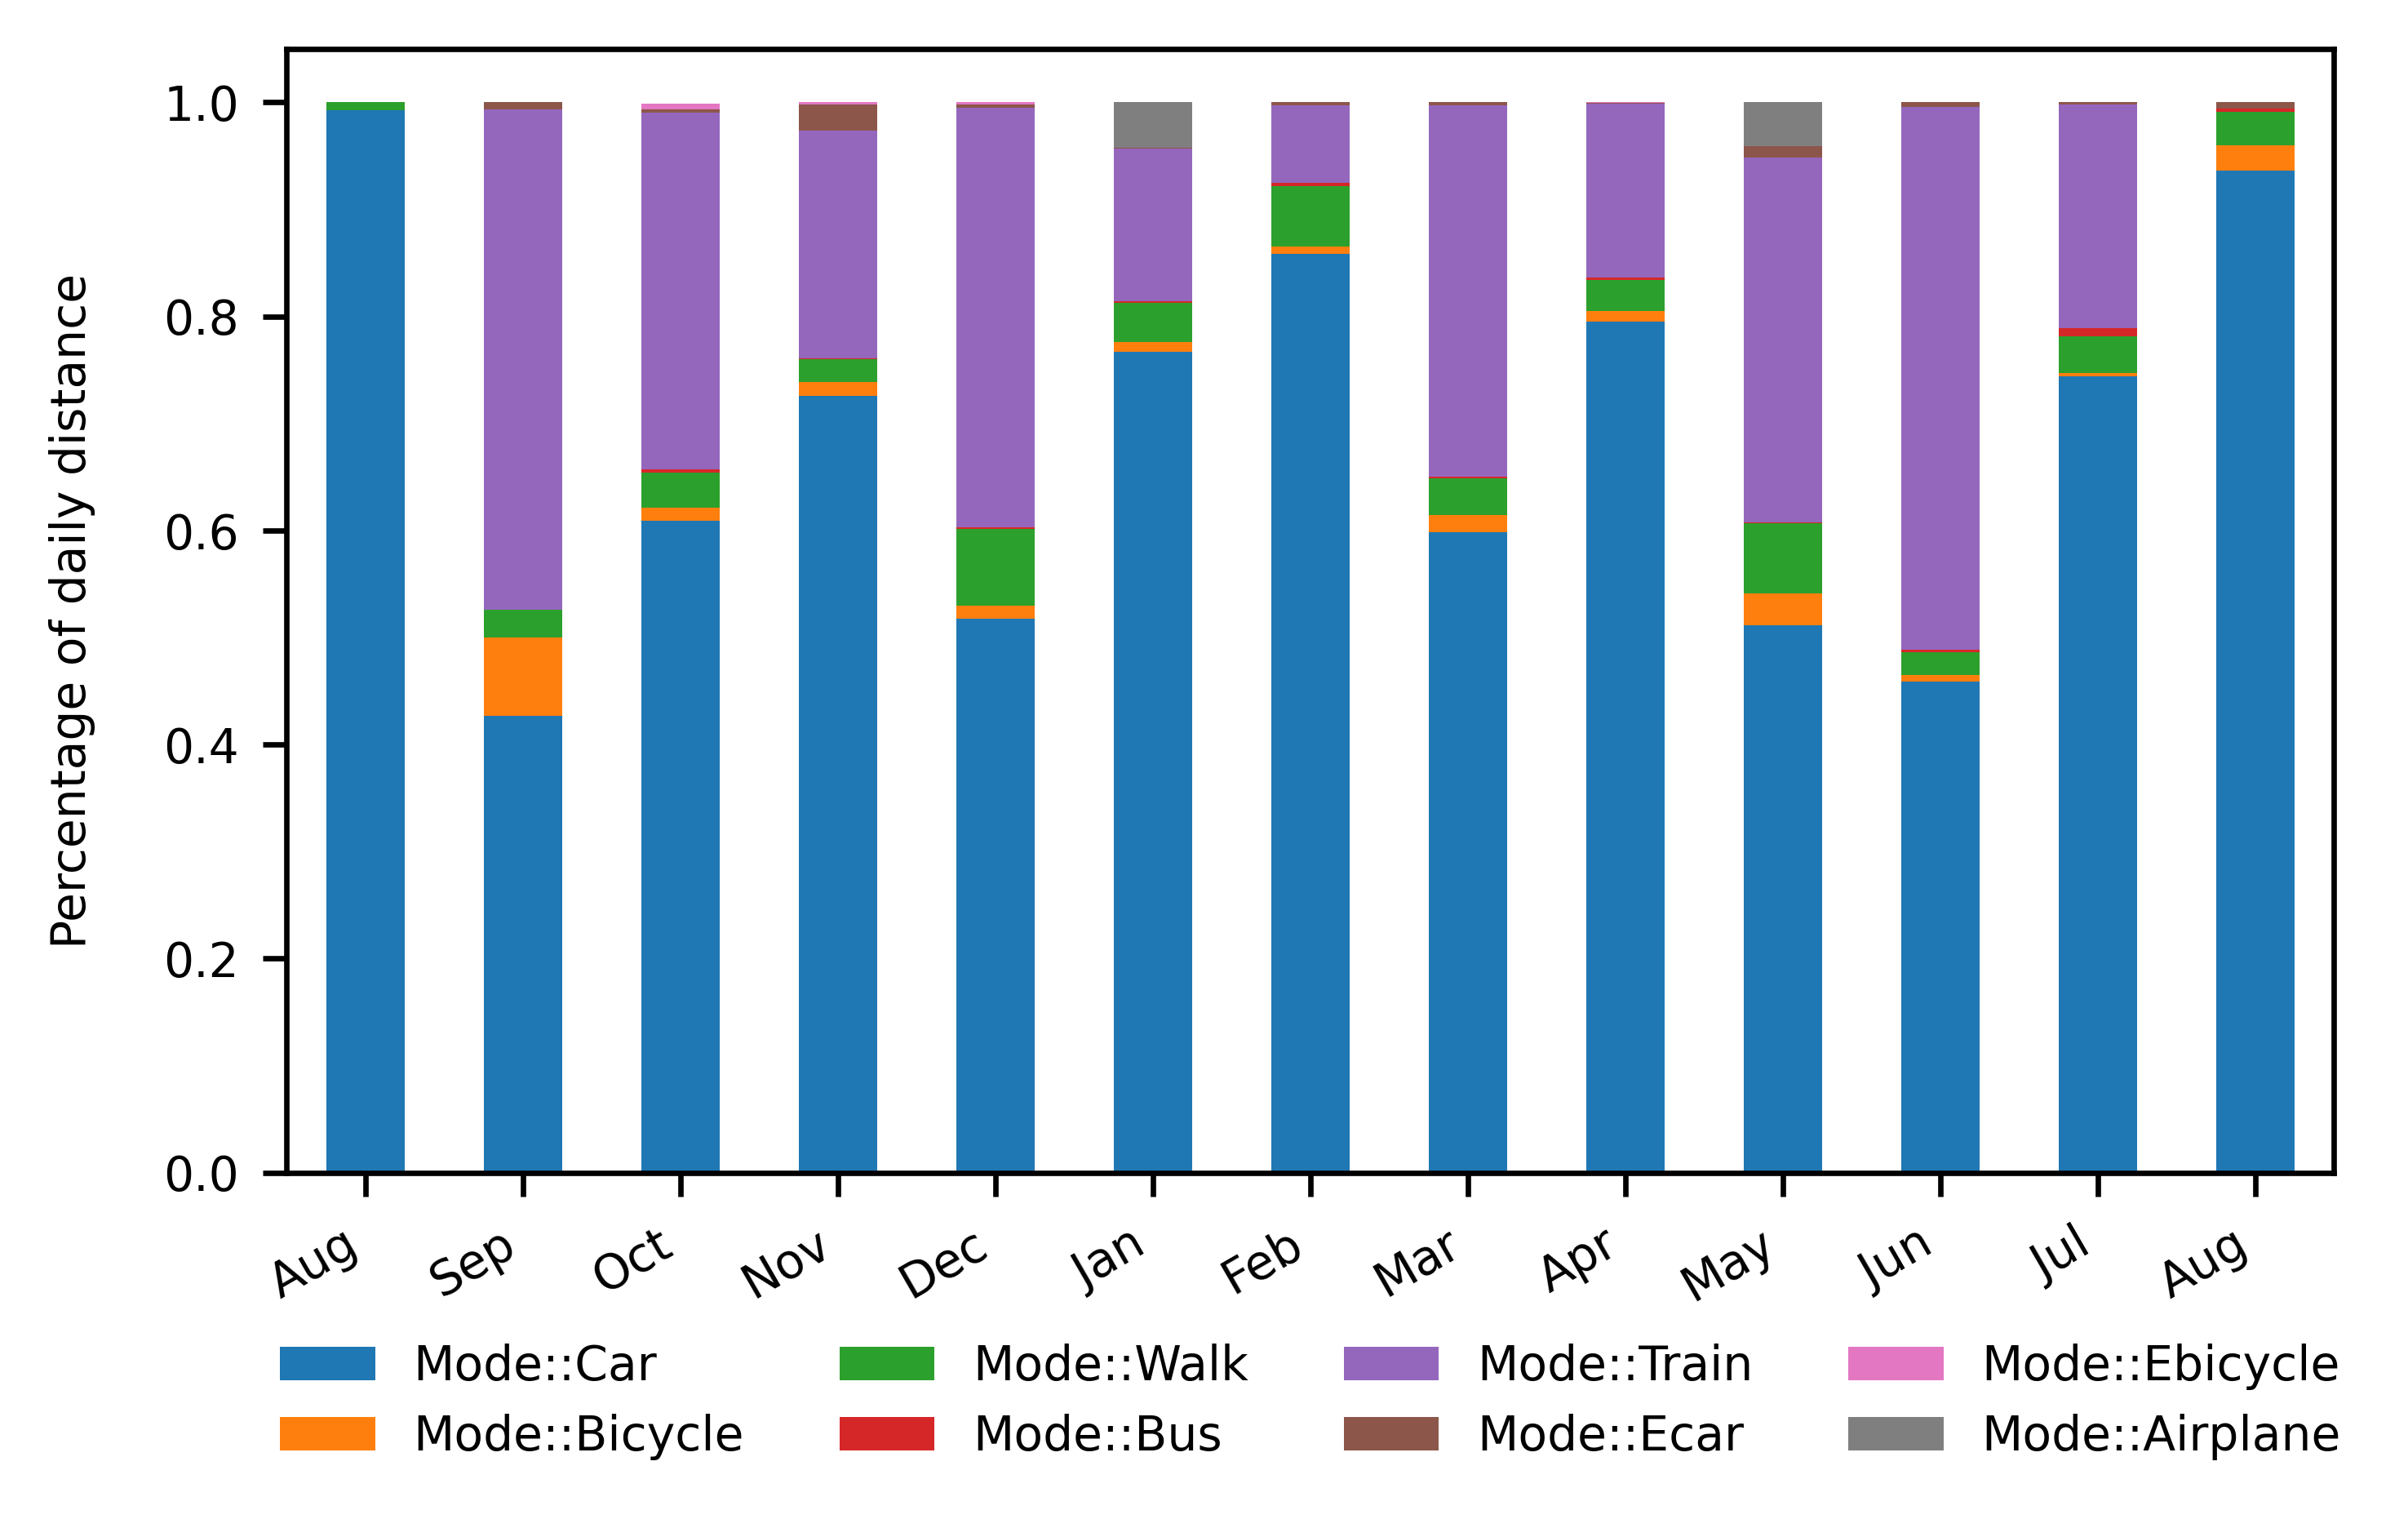

In [107]:
fig, ax = plt.subplots(figsize=(5,3))
ax = ti.visualization.modal_split.plot_modal_split(modal_split, 
                                              date_fmt_x_axis='%b',
                                              y_label='Percentage of daily distance',
                                              skip_xticks=0,
                                              n_col_legend=4,
                                              fig=fig,
                                              axis=ax,
                                             borderaxespad=2
                                             )
fig.autofmt_xdate()
plt.savefig(os.path.join(out_path, "modal_split_distance"))